# Introduction

In this notebook, we are going to follow some data wrangling, including cleaning and organizing steps on a raw dataset, scraped from the audible website.
This is a good example of several required steps for data cleansing process, which is necessary usually to make the data ready for next steps such as analysis.

The dataset is available online in Kaggle under the public domain: https://www.kaggle.com/datasets/snehangsude/audible-dataset?select=audible_uncleaned.csv but in this notebook we use the locally available file named "audible_uncleaned.csv".
The output is written to a new file called "audible_cleaned.csv"

In [1]:
#import the required libraries needed in the notebook

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

import os

In [2]:
# red the raw dataset

file_path = os.path.join('data', 'audible_uncleaned.csv')
audio_df = pd.read_csv(file_path)

Let's see the schema and the number of rows in this dataset.

In [3]:
audio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87489 entries, 0 to 87488
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         87489 non-null  object
 1   author       87489 non-null  object
 2   narrator     87489 non-null  object
 3   time         87489 non-null  object
 4   releasedate  87489 non-null  object
 5   language     87489 non-null  object
 6   stars        87489 non-null  object
 7   price        87489 non-null  object
dtypes: object(8)
memory usage: 5.3+ MB


Let's see how the data looks like.

In [4]:
audio_df.head()

,name,author,narrator,time,releasedate,language,stars,price
0,Geronimo Stilton #11 & #12,Writtenby:GeronimoStilton,Narratedby:BillLobely,2 hrs and 20 mins,04-08-08,English,5 out of 5 stars34 ratings,468.00
1,The Burning Maze,Writtenby:RickRiordan,Narratedby:RobbieDaymond,13 hrs and 8 mins,01-05-18,English,4.5 out of 5 stars41 ratings,820.00
2,The Deep End,Writtenby:JeffKinney,Narratedby:DanRussell,2 hrs and 3 mins,06-11-20,English,4.5 out of 5 stars38 ratings,410.00
3,Daughter of the Deep,Writtenby:RickRiordan,Narratedby:SoneelaNankani,11 hrs and 16 mins,05-10-21,English,4.5 out of 5 stars12 ratings,615.00
4,"The Lightning Thief: Percy Jackson, Book 1",Writtenby:RickRiordan,Narratedby:JesseBernstein,10 hrs,13-01-10,English,4.5 out of 5 stars181 ratings,820.00


We could observe that most of the columns need some kinds of processing and fixing the data formats. All columns are defined as string while we shoud cast some of those to the proper types to make the later analyis easier and faster. The datatype of the first three columns looks fine but the rest of clumns should be converted to the adequate data type. We also need to clean some columns from extra and unnecessary data, e.g. the "author" and "narrator" columns. 

Now let's get a simple statistical overview of the data that reveals intersting points.

In [5]:
audio_df.describe().T

,count,unique,top,freq
name,87489,82767,The Art of War,20
author,87489,48374,"Writtenby:矢島雅弘,石橋遊",874
narrator,87489,29717,Narratedby:anonymous,1034
time,87489,2284,2 mins,372
releasedate,87489,5058,16-05-18,773
language,87489,36,English,61884
stars,87489,665,Not rated yet,72417
price,87489,1011,586.00,5533


From this output we can get more information about the data distributions, null data, etc.  For instance we notice that the "language" column inlcudes only 36 different languages across whole 87489 rows of data. Then by simply converting this column to category type, we will save too much space which is of course of high improtance while dealing with large datasets. Also we could see that some columns, such as "narrator" and "stars", include null data, although the column itseld has no null value but the value is indicating that there is no information included.

# Cleaning the dataset

In continue, we follow the cleaning process in the order of the columns in the datafarme.

### The "authors" column

In [6]:
audio_df['author'] = audio_df['author'].str[10:].str.replace(r'([a-z])([A-Z])', r'\1 \2')

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


### The "narrator" column

In [7]:
audio_df['narrator'] = audio_df['narrator'].str.strip()

# set the null values
audio_df.loc[audio_df['narrator'] == 'Narratedby:anonymous', 'narrator'] = np.NaN

# reformat the column
audio_df['narrator'] = audio_df['narrator'].str[11:].str.replace(r'([a-z])([A-Z])', r'\1 \2')

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


### The "time" column

By scrolling a bit the data, we realize that the values does not have a similar string patern. Some values include both hours and minues and some others include one of these two. This needs to be taken into account in our data processing.Therefore we define a function to consider all cases and apply it to the dataframe.

In [8]:
# this funtion extract the hours and minutes from the string values in the 'time' column 
def clean_time(time_str):
    if 'Less than 1' in time_str:
        hours_str = '0'
        minutes_str = '0'
    elif 'hr' in time_str:
        hours_str = time_str.partition(' hr')[0]
        minutes_str = time_str.partition('and ')[2].partition(' min')[0]
        if minutes_str =='' or minutes_str == 'Less than 1':
            minutes_str = '0'
    else:
        hours_str = '0'
        minutes_str = time_str.partition(' min')[0]
        
    return timedelta(hours=int(hours_str), minutes=int(minutes_str))

# we apply this function to the 'time' column and store the cleaned values in a new column called 'duration'
audio_df['duration'] = audio_df['time'].apply(clean_time)

#we do not need the 'time' columns so drop it
audio_df.drop(['time'], axis=1, inplace=True)

### The "releasedate" column

for this column, simply the type conversion is enough.

In [9]:
audio_df['releasedate'] = pd.to_datetime(audio_df['releasedate'])

#rename the column for more readability
audio_df.rename(columns = {'releasedate':'release_date'}, inplace = True)

### The "language" column

The only step required for this column is converting it to the "category" data type.

In [10]:
audio_df['language'] = audio_df['language'].astype('category')

audio_df['language'].unique()

['English', 'Hindi', 'spanish', 'german', 'french', ..., 'ukrainian', 'slovene', 'norwegian', 'telugu', 'lithuanian']
Length: 36
Categories (36, object): ['English', 'Hindi', 'afrikaans', 'arabic', ..., 'telugu', 'turkish', 'ukrainian', 'urdu']

### The "star" column

This columns include two piece of information that need to be extracted to new columns.
- The rating score
- The number of ratings

In [11]:
audio_df['stars'] = audio_df['stars'].str.strip()

#setting the null value of the 'stars' colums
audio_df.loc[audio_df['stars'] == 'Not rated yet', 'stars'] = np.NaN

#splitting the information of the 'stars' columns to two new columns and removing the 'stars' column
audio_df['rating_score'] = audio_df['stars'].str.partition('out ')[0]
audio_df['rating_no'] = audio_df['stars'].str.partition('stars')[2].str.partition(' rating')[0]
audio_df.drop(['stars'], axis=1, inplace=True)

# converting the new columns to numbers
audio_df['rating_score'] = pd.to_numeric(audio_df['rating_score'])

# if we try to simply convert the 'rating_no' column to number we got a ValueError because
# the numbers grether than 999 are include comma as seperator in their string, e.g. 1,423
# then we need to remover this commas fisrt
audio_df['rating_no'] = audio_df['rating_no'].str.replace(',','')

audio_df['rating_no'] = pd.to_numeric(audio_df['rating_no'])

### The "price" column

To type cast this column, we need to first get rid of commas as we did for the "rating_no" column

In [12]:
audio_df['price'] = audio_df['price'].str.replace(',','')
audio_df['price'] = audio_df['price'].str.replace('Free','0')

audio_df['price'] = pd.to_numeric(audio_df['price'])

# Storing the cleaned data

Now we completed the cleaning and we store the data to a anew dataset for the next exploratory analysis.

In [13]:
audio_df

,name,author,narrator,release_date,language,price,duration,rating_score,rating_no
0,Geronimo Stilton #11 & #12,Geronimo Stilton,Bill Lobely,2008-04-08,English,468.0,0 days 02:20:00,5.0,34.0
1,The Burning Maze,Rick Riordan,Robbie Daymond,2018-01-05,English,820.0,0 days 13:08:00,4.5,41.0
2,The Deep End,Jeff Kinney,Dan Russell,2020-06-11,English,410.0,0 days 02:03:00,4.5,38.0
3,Daughter of the Deep,Rick Riordan,Soneela Nankani,2021-05-10,English,615.0,0 days 11:16:00,4.5,12.0
4,"The Lightning Thief: Percy Jackson, Book 1",Rick Riordan,Jesse Bernstein,2010-01-13,English,820.0,0 days 10:00:00,4.5,181.0
...,...,...,...,...,...,...,...,...,...
87484,Last Days of the Bus Club,Chris Stewart,Chris Stewart,2017-09-03,English,596.0,0 days 07:34:00,NaN,NaN
87485,The Alps,Stephen O'Shea,Robert Fass,2017-02-21,English,820.0,0 days 10:07:00,NaN,NaN
87486,The Innocents Abroad,Mark Twain,Flo Gibson,2016-12-30,English,938.0,0 days 19:04:00,NaN,NaN
87487,A Sentimental Journey,Laurence Sterne,Anton Lesser,2011-02-23,English,680.0,0 days 04:08:00,NaN,NaN


In [14]:
audio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87489 entries, 0 to 87488
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   name          87489 non-null  object         
 1   author        87489 non-null  object         
 2   narrator      86455 non-null  object         
 3   release_date  87489 non-null  datetime64[ns] 
 4   language      87489 non-null  category       
 5   price         87489 non-null  float64        
 6   duration      87489 non-null  timedelta64[ns]
 7   rating_score  15072 non-null  float64        
 8   rating_no     15072 non-null  float64        
dtypes: category(1), datetime64[ns](1), float64(3), object(3), timedelta64[ns](1)
memory usage: 5.4+ MB


From this info, we observe that the cleaned dataset includes many null values.
To have a better imagination about the null values let's observe the situation graphically by the followinh heatmap.

<AxesSubplot:>

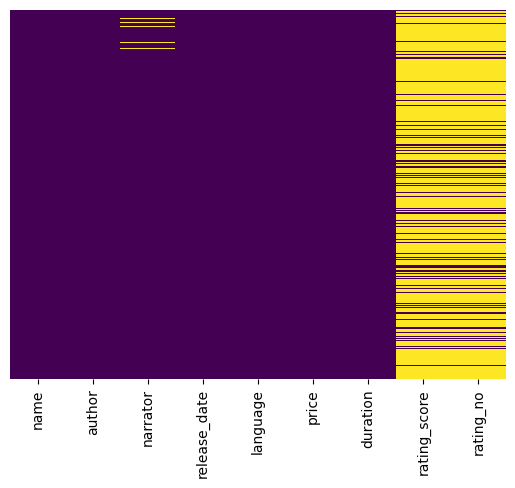

In [15]:
sns.heatmap(audio_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

We observe too much null values for rating. If we decide ti simply remove all the rows including null ratings, we loose more tan 80% of the data (from the info() output we have total rows of 87489 including 15072 not null value for rating) which is a lot. Depending on the analysis purpose we shoul find the best wat to deal with these missed information, such as removing the rows including null values, ignoring the rating columns totally, data imputation, etc.

In [16]:
file_path = os.path.join('data', 'audible_cleaned.csv')
audio_df.to_csv(file_path)

Now the data is stored ina anew file and we can proceed for required exploratory analysis from this clean dataset.